<div style="display: flex; background-color: RGB(87, 100, 144);">
<h1 style="margin: auto; padding: 30px 30px 10px 30px;">P2 - Analyze data from Education Systems</h1>
</div>
<div style="display: flex; background-color: RGB(87, 100, 144);">
<h2 style="margin: auto; padding: 10px 30px 30px 30px;">Data Scientist course</h2>
</div>

# Table of Contents

* [Chapter 1. Libraries and functions](#chapter1)
    * [1.1. Importing libraries](#section_1_1)
    * [1.2. Functions declaration](#Section_1_2)
* [Chapter 2. Importing files](#chapter2)
    * [2.1. Importing and preparing files](#section_2_1)
* [Chapter 3. Initial Data Analysis](#chapter3)
    * [3.1. Initial Data Analysis Summary based on load](#section_3_1)
    * [3.2. Selecting the datasets and columns to work on](#section_3_2)
    * [3.3. Making the initial cleaning](#section_3_3)
        * [3.3.1 Cleaning "EdStatsData.csv" dataset](#section_3_3_1)
            
            
            
        * [3.3.2. Cleaning "EdStatsCountry.csv" dataset](#section_3_3_12)

## Chapter 1.

<a class="anchor" id="chapter1"></a>
<div style="background-color: RGB(119, 150, 203);" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">Libraries and functions</h2>
</div>

#### 1.1.

<a class="anchor" id="section_1_1"></a>
<div style="border: 1px solid RGB(119, 150, 203);" >
    <h3 style="margin: auto; padding: 20px; color: RGB(119, 150, 203); ">1.1. Importing libraries</h3>
</div>

In [1]:
import io
from math import prod
import pandas as pd
import matplotlib .pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()

#### 1.2.

<a class="anchor" id="Section_1_2"></a>
<div style="border: 1px solid RGB(119, 150, 203);" >
    <h3 style="margin: auto; padding: 20px; color: RGB(119, 150, 203); ">1.2. Functions declaration</h3>
</div>

In [2]:
def df_initial_analysis(df, columns, name_df):
    """
    Initial analysis on the DataFrame.

    Args:
        df (pandas.DataFrame): DataFrame to analyze.
        name_df (str): DataFrame name.

    Returns:
        None.
        Print the initial analysis on the DataFrame. 
    """
    
    # Calculating the memory usage based on dataframe.info()
    buf = io.StringIO()
    df.info(buf=buf)
    memory_usage = buf.getvalue().split('\n')[-2]
  
    if df.empty:
        print("The", name_df, "dataset is empty. Please verify the file.")
    else:
        empty_cols = [col for col in df.columns if df[col].isna().all()] # identifying empty columns
        df_rows_duplicates = df[df.duplicated()] #identifying full duplicates rows
        
        # Creating a dataset based on Type object and records by columns
        type_cols = df.dtypes.apply(lambda x: x.name).to_dict() 
        df_resume = pd.DataFrame(list(type_cols.items()), columns = ["Name", "Type"])
        df_resume["Records"] = list(df.count())
        
        print("\nInitial Analysis of", name_df, "dataset")
        print("--------------------------------------------------------------------------")
        print("- Dataset shape:                 ", df.shape[0], "rows and", df.shape[1], "columns")
        print("- Total of NaN values:           ", df.isna().sum().sum())
        print("- Percentage of NaN:             ", round((df.isna().sum().sum() / prod(df.shape)) * 100, 2), "%")
        print("- Total of full duplicates rows: ", df_rows_duplicates.shape[0])
        print("- Total of empty rows:           ", df.shape[0] - df.dropna(axis="rows", how="all").shape[0]) if df.dropna(axis="rows", how="all").shape[0] < df.shape[0] else \
                    print("- Total of empty rows:            0")
        print("- Total of empty columns:        ", len(empty_cols))
        print("  + The empty column is:         ", empty_cols) if len(empty_cols) == 1 else \
                    print("  + The empty column are:         ", empty_cols) if len(empty_cols) >= 1 else None
        
        print("\n- The key(s):", columns, "is not present multiple times in the dataframe.\n  It CAN be used as a primary key.") if df.size == df.drop_duplicates(columns).size else \
                    print("\n- The key(s):", columns, "is present multiple times in the dataframe.\n  It CANNOT be used as a primary key.")
        
        print("\n- Type object and records by columns         (",memory_usage,")")
        print("--------------------------------------------------------------------------")
        print(df_resume.sort_values("Records", ascending=False))
        

def comparison_dfs(df_original, df_copy):
    """
    Create a DataFrame based on comparación between the original DataFrame and the copy DataFrame.
    Args:
        df_original (pandas.DataFrame): DataFrame original.
        df_copy (pandas.DataFrame): DataFrame copy.
    Returns:
        df_comparison (pandas.DataFrame): DataFrame comparison.
    """
    df_comparison = pd.DataFrame({
        "Moment" : ["Before", "After"],
        "Total values" : [prod(df_original.shape), prod(df_copy.shape)], 
        "Valid values" : [(prod(df_original.shape)-df_original.isna().sum().sum()), (prod(df_copy.shape)-df_copy.isna().sum().sum())],
        "Missing values" : [df_original.isna().sum().sum(), df_copy.isna().sum().sum()]
    })
    return df_comparison

## Chapter 2.


<a class="anchor" id="chapter2"></a>
<div style="background-color: RGB(119, 150, 203);" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">Importing files</h2>
</div>

#### 2.1.

<a class="anchor" id="section_2_1"></a>
<div style="border: 1px solid RGB(119, 150, 203);" >
    <h3 style="margin: auto; padding: 20px; color: RGB(119, 150, 203); ">2.1. Importing and preparing files</h3>
</div>

In [3]:
# Importing EdStatsCountry dataset
df_country = pd.read_csv("datasets/EdStatsCountry.csv")
df_country.head(3)

,Country Code,Short Name,Table Name,Long Name,2-alpha code,Currency Unit,Special Notes,Region,Income Group,WB-2 code,...,IMF data dissemination standard,Latest population census,Latest household survey,Source of most recent Income and expenditure data,Vital registration complete,Latest agricultural census,Latest industrial data,Latest trade data,Latest water withdrawal data,Unnamed: 31
0,ABW,Aruba,Aruba,Aruba,AW,Aruban florin,SNA data for 2000-2011 are updated from offici...,Latin America & Caribbean,High income: nonOECD,AW,...,NaN,2010,NaN,NaN,Yes,NaN,NaN,2012.0,NaN,NaN
1,AFG,Afghanistan,Afghanistan,Islamic State of Afghanistan,AF,Afghan afghani,Fiscal year end: March 20; reporting period fo...,South Asia,Low income,AF,...,General Data Dissemination System (GDDS),1979,"Multiple Indicator Cluster Survey (MICS), 2010/11","Integrated household survey (IHS), 2008",NaN,2013/14,NaN,2012.0,2000,NaN
2,AGO,Angola,Angola,People's Republic of Angola,AO,Angolan kwanza,"April 2013 database update: Based on IMF data,...",Sub-Saharan Africa,Upper middle income,AO,...,General Data Dissemination System (GDDS),1970,"Malaria Indicator Survey (MIS), 2011","Integrated household survey (IHS), 2008",NaN,2015,NaN,NaN,2005,NaN


In [4]:
# initial analysis of dataset
df_initial_analysis(df_country, ["Country Code"], "country")


Initial Analysis of country dataset
--------------------------------------------------------------------------
- Dataset shape:                  241 rows and 32 columns
- Total of NaN values:            2354
- Percentage of NaN:              30.52 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         1
  + The empty column is:          ['Unnamed: 31']

- The key(s): ['Country Code'] is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns         ( memory usage: 60.4+ KB )
--------------------------------------------------------------------------
                                                 Name     Type  Records
0                                        Country Code   object      241
3                                           Long Name   object      241
1                                          Short Name   object      241
2                                       

<div style="color: RGB(255,114,0);">
    <h3 >Initial analysis of dataset "EdStatsCountry"</h3>
    - This dataset has general economic and geographic information about countries.<br/>
    - The primary key is unique.<br/>
    - There is no null row.<br/>
    - For this dataset, there are no problems.<br/>
    - There is only one null column, but it is a ghost column. 
    - The percentage of null is reasonable, but we should wait to review all dataset to consider that.
</div>

In [5]:
# Importing EdStatsSeries dataset
df_serie = pd.read_csv("datasets/EdStatsSeries.csv")
df_serie.head(3)

,Series Code,Topic,Indicator Name,Short definition,Long definition,Unit of measure,Periodicity,Base Period,Other notes,Aggregation method,...,Notes from original source,General comments,Source,Statistical concept and methodology,Development relevance,Related source links,Other web links,Related indicators,License Type,Unnamed: 20
0,BAR.NOED.1519.FE.ZS,Attainment,Barro-Lee: Percentage of female population age...,Percentage of female population age 15-19 with...,Percentage of female population age 15-19 with...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Robert J. Barro and Jong-Wha Lee: http://www.b...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BAR.NOED.1519.ZS,Attainment,Barro-Lee: Percentage of population age 15-19 ...,Percentage of population age 15-19 with no edu...,Percentage of population age 15-19 with no edu...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Robert J. Barro and Jong-Wha Lee: http://www.b...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BAR.NOED.15UP.FE.ZS,Attainment,Barro-Lee: Percentage of female population age...,Percentage of female population age 15+ with n...,Percentage of female population age 15+ with n...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Robert J. Barro and Jong-Wha Lee: http://www.b...,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# initial analysis of dataset
df_initial_analysis(df_serie, ["Series Code"], "series")


Initial Analysis of series dataset
--------------------------------------------------------------------------
- Dataset shape:                  3665 rows and 21 columns
- Total of NaN values:            55203
- Percentage of NaN:              71.72 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         6
  + The empty column are:          ['Unit of measure', 'Notes from original source', 'Other web links', 'Related indicators', 'License Type', 'Unnamed: 20']

- The key(s): ['Series Code'] is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns         ( memory usage: 601.4+ KB )
--------------------------------------------------------------------------
                                   Name     Type  Records
0                           Series Code   object     3665
13                               Source   object     3665
2                        Indicator Name   obje

<div style="color: RGB(255,114,0);">
    <h3 >Initial analysis of dataset "EdStatsSeries"</h3>
    - This dataset has general information about indicators.<br/>
    - The primary key is unique.<br/>
    - There is no null row.<br/>
    - For this dataset, there are problems.<br/>
    - Most of the data is null in the dataset.<br/>
    - There are 6 null columns.<br/>
    - Most of the data is null in the dataset, but we should wait to review all dataset to consider that.<br/>
    - We could consider Topic column to group indicators by it. 
</div>

In [7]:
# Importing EdStatsCountry-Series dataset
df_country_series = pd.read_csv("datasets/EdStatsCountry-Series.csv")
df_country_series.head(3)

,CountryCode,SeriesCode,DESCRIPTION,Unnamed: 3
0,ABW,SP.POP.TOTL,Data sources : United Nations World Population...,NaN
1,ABW,SP.POP.GROW,Data sources: United Nations World Population ...,NaN
2,AFG,SP.POP.GROW,Data sources: United Nations World Population ...,NaN


In [8]:
# initial analysis of dataset
df_initial_analysis(df_country_series, ["CountryCode", "SeriesCode"], "country-series")


Initial Analysis of country-series dataset
--------------------------------------------------------------------------
- Dataset shape:                  613 rows and 4 columns
- Total of NaN values:            613
- Percentage of NaN:              25.0 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         1
  + The empty column is:          ['Unnamed: 3']

- The key(s): ['CountryCode', 'SeriesCode'] is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns         ( memory usage: 19.3+ KB )
--------------------------------------------------------------------------
          Name     Type  Records
0  CountryCode   object      613
1   SeriesCode   object      613
2  DESCRIPTION   object      613
3   Unnamed: 3  float64        0


<div style="color: RGB(255,114,0);">
    <h3 >Initial analysis of dataset "EdStatsCountry-Series"</h3>
    - This dataset has information related between "Country" dataset and "Serie" datasets.<br/>
    - For this dataset, there are no problems.<br/>
    - Initially, we can rule out this dataset, but we should wait to review all dataset to consider that.
</div>

In [9]:
# Importing EdStatsFootNote dataset
df_foot_note = pd.read_csv("datasets/EdStatsFootNote.csv")
df_foot_note.head(3)

,CountryCode,SeriesCode,Year,DESCRIPTION,Unnamed: 4
0,ABW,SE.PRE.ENRL.FE,YR2001,Country estimation.,NaN
1,ABW,SE.TER.TCHR.FE,YR2005,Country estimation.,NaN
2,ABW,SE.PRE.TCHR.FE,YR2000,Country estimation.,NaN


In [10]:
# initial analysis of dataset
df_initial_analysis(df_foot_note, ["CountryCode", "SeriesCode"], "foot-note")


Initial Analysis of foot-note dataset
--------------------------------------------------------------------------
- Dataset shape:                  643638 rows and 5 columns
- Total of NaN values:            643638
- Percentage of NaN:              20.0 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         1
  + The empty column is:          ['Unnamed: 4']

- The key(s): ['CountryCode', 'SeriesCode'] is present multiple times in the dataframe.
  It CANNOT be used as a primary key.

- Type object and records by columns         ( memory usage: 24.6+ MB )
--------------------------------------------------------------------------
          Name     Type  Records
0  CountryCode   object   643638
1   SeriesCode   object   643638
2         Year   object   643638
3  DESCRIPTION   object   643638
4   Unnamed: 4  float64        0


<div style="color: RGB(255,114,0);">
    <h3 >Initial analysis of dataset "EdStatsFootNote"</h3>
    - Similar to EdStatsFootNote dataset, this dataset has information related between "Country" dataset and "Serie" datasets.<br/>
    - For this dataset, there are no problems.<br/>
    - Initially, we can rule out this dataset, but we should wait to review all dataset to consider that.
</div>

In [11]:
# Importing EdStatsData dataset
df_data = pd.read_csv("datasets/EdStatsData.csv")
df_data.head(10)

,Country Name,Country Code,Indicator Name,Indicator Code,1970,1971,1972,1973,1974,1975,...,2060,2065,2070,2075,2080,2085,2090,2095,2100,Unnamed: 69
0,Arab World,ARB,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Arab World,ARB,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2.F,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Arab World,ARB,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2.GPI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Arab World,ARB,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2.M,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Arab World,ARB,"Adjusted net enrolment rate, primary, both sex...",SE.PRM.TENR,54.822121,54.894138,56.209438,57.267109,57.991138,59.365540,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Arab World,ARB,"Adjusted net enrolment rate, primary, female (%)",SE.PRM.TENR.FE,43.351101,43.318150,44.640701,45.845718,46.449501,48.363892,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Arab World,ARB,"Adjusted net enrolment rate, primary, gender p...",UIS.NERA.1.GPI,0.658570,0.656400,0.663290,0.672040,0.672610,0.691760,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Arab World,ARB,"Adjusted net enrolment rate, primary, male (%)",SE.PRM.TENR.MA,65.826233,65.993584,67.301857,68.219078,69.059013,69.914551,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Arab World,ARB,"Adjusted net enrolment rate, upper secondary, ...",UIS.NERA.3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Arab World,ARB,"Adjusted net enrolment rate, upper secondary, ...",UIS.NERA.3.F,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# initial analysis of dataset
df_initial_analysis(df_data, ["Country Code", "Indicator Code"], "data")


Initial Analysis of data dataset
--------------------------------------------------------------------------
- Dataset shape:                  886930 rows and 70 columns
- Total of NaN values:            53455179
- Percentage of NaN:              86.1 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         1
  + The empty column is:          ['Unnamed: 69']

- The key(s): ['Country Code', 'Indicator Code'] is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns         ( memory usage: 473.7+ MB )
--------------------------------------------------------------------------
              Name     Type  Records
0     Country Name   object   886930
2   Indicator Name   object   886930
3   Indicator Code   object   886930
1     Country Code   object   886930
44            2010  float64   242442
..             ...      ...      ...
7             1973  float64    35545
5         

<div style="color: RGB(255,114,0);">
    <h3 >Initial analysis of dataset "EdStatsData"</h3>
    - It seems the main dataset. It has the information by country, indicator and multiple years.<br/>
    - There is only on column null, but it is a ghost column.<br/>
    - The primary key combination is unique.<br/>
    - For this dataset, there are some problems.<br/> 
    - In the firts rows, we can see a conutry name called Arab World, so... it is necesary verify all countries in dataset.<br/>
    - Most of the data is null in the dataset, but we should wait to select the countries/indicators to analyze to verify that point.<br/>
    - Despite the amount of null data in dataset, it has a lot of data. 
</div>

## Chapter 3.

<a class="anchor" id="chapter3"></a>
<div style="background-color: RGB(119, 150, 203);" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">Initial Data Analysis</h2>
</div>

#### 3.1.

<a class="anchor" id="section_3_1"></a>
<div style="border: 1px solid RGB(119, 150, 203);" >
    <h3 style="margin: auto; padding: 20px; color: RGB(119, 150, 203); ">3.1. Initial Data Analysis Summary based on load</h3>
</div>

- Knowing the entities of the datasets.<br>
    - **`Country`** dataset **`"EdStatsCountry.csv"`**.<br>
    General economic and geographic information about countries in the world.
    
    - **`Serie`** dataset **`"EdStatsSeries.csv"`**.<br>
    General information about indicators.
    
    - **`Country-Serie`** dataset **`"EdStatsCountry-Series.csv"`**.<br>
    Information related between "Country" dataset and "Serie" datasets.<br>
    In fact, it contains the indicators descriptions related with countries.

    - **`Foot Note`** dataset **`"EdStatsFootNote.csv"`**.<br>
    Similar to **`Country-Serie`**. It has Information related between "Country" dataset and "Serie" datasets.<br>
    In fact, it contains the year of origin of the data and also a description of the indicators.

    - **`Data`** dataset **`"EdStatsData.csv"`**.<br>
    The main dataset that contains in details the information about countries and indicators by years.
    
- Relations between datasets.<br>
    - We can see some **"relations"** between datasets through the columns below.<br>
    The relation could be with one of these fields or the combination of both.<br>
        - **`"Country code"`** / **`"CountryCode"`**
        - **`"Series code"`** / **`"Indicator code"`**
    - Getting as a result an Entity relationship diagram as follow.<br>
    But, we must be **careful** with these relationships.<br>
    ![Entity relationship diagram](img/entity_relationship.png)

#### 3.2.

<a class="anchor" id="section_3_2"></a>
<div style="border: 1px solid RGB(119, 150, 203);" >
    <h3 style="margin: auto; padding: 20px; color: RGB(119, 150, 203); ">3.2. Select the datasets and columns to work on</h3>
</div>

Based on the context of the problem, the following datasets are interesting. 

- The datasets to works are:<br>
    - **`"EdStatsData.csv"`** : The main dataset.
    - **`"EdStatsCountry.csv"`** : To complete information about countries. 
    - **`"EdStatsSeries.csv"`** : **Optional** to complete the topic about series.
        
     ![Entity relationship diagram](img/entity_relationship_selected.png)<br>
<br>

- The columns by dataset to consider are:<br> 
    - **`"EdStatsData.csv"`**
        - Country Name
        - Country Code
        - Indicator Name
        - Indicator Code
        - Years until 2021 (current year)<br>
    - **`"EdStatsCountry.csv"`**
        - Country Code
        - Short Name
        - 2-alpha code
        - Region
        - Income Group<br>
    - **`"EdStatsSeries.csv"`**
        - Series Code
        - Topic

#### 3.3.

<a class="anchor" id="section_3_3"></a>
<div style="border: 1px solid RGB(119, 150, 203);" >
    <h3 style="margin: auto; padding: 20px; color: RGB(119, 150, 203); ">3.3. Making the initial cleaning</h3>
</div>

##### 3.3.1.

<a class="anchor" id="section_3_3_1"></a>
<div style="border: 1px solid RGB(68,180,231);" >
    <h4 style="margin: auto; padding: 20px; color: RGB(68,180,231); ">3.3.1. Cleaning "EdStatsData.csv" dataset</h4>
</div>

Maybe the other datasets don't have the same records so, due to that, this is the dataset to work. 
Below the steps to clean this dataset. 
1. Removing the NaN columns and rows present in the dataset
2. Adding the following columns from **`"EdStatsCountry.csv"`** dataset
    - Region: To group by Region of country
    - 2-alpha code: To filter based on list of countries as given in ISO 3166-1
    - Income Group: To group by income group
3. Removing rows that aren't countries based on list of countries as given in ISO 3166-1
4. Adding the columns Topic from "EdStatsSeries.csv" to identify more in details the indicator

In [27]:
# copying the dataset into new dataset and removing the NaN columns to work on it
df_data_copy = df_data.dropna(axis="columns", how="all").dropna(axis="rows", how="all")

In [28]:
# Adding in "EdStatsData.csv" dataset, the columns Region, 2-alpha code and Income Group from "EdStatsCountry.csv" dataset
df_data_copy = df_data_copy.merge(right=df_country_copy[["Country Code", "Region", "2-alpha code", "Income Group"]], on="Country Code", how="left")

In [34]:
df_data_copy.tail(10)

,Country Name,Country Code,Indicator Name,Indicator Code,1970,1971,1972,1973,1974,1975,...,2070,2075,2080,2085,2090,2095,2100,Region,2-alpha code,Income Group
886920,Zimbabwe,ZWE,Wittgenstein Projection: Population in thousan...,PRJ.POP.ALL.3.MA,NaN,NaN,NaN,NaN,NaN,NaN,...,3041.50,3000.74,2961.23,2924.73,2889.02,2851.65,2813.31,Sub-Saharan Africa,ZW,Low income
886921,Zimbabwe,ZWE,Wittgenstein Projection: Population in thousan...,PRJ.POP.ALL.3.MF,NaN,NaN,NaN,NaN,NaN,NaN,...,6533.22,6469.39,6390.77,6303.34,6206.69,6100.56,5988.95,Sub-Saharan Africa,ZW,Low income
886922,Zimbabwe,ZWE,"Youth illiterate population, 15-24 years, % fe...",UIS.LPP.AG15T24,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sub-Saharan Africa,ZW,Low income
886923,Zimbabwe,ZWE,"Youth illiterate population, 15-24 years, both...",UIS.LP.AG15T24,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sub-Saharan Africa,ZW,Low income
886924,Zimbabwe,ZWE,"Youth illiterate population, 15-24 years, fema...",UIS.LP.AG15T24.F,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sub-Saharan Africa,ZW,Low income
886925,Zimbabwe,ZWE,"Youth illiterate population, 15-24 years, male...",UIS.LP.AG15T24.M,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sub-Saharan Africa,ZW,Low income
886926,Zimbabwe,ZWE,"Youth literacy rate, population 15-24 years, b...",SE.ADT.1524.LT.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sub-Saharan Africa,ZW,Low income
886927,Zimbabwe,ZWE,"Youth literacy rate, population 15-24 years, f...",SE.ADT.1524.LT.FE.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sub-Saharan Africa,ZW,Low income
886928,Zimbabwe,ZWE,"Youth literacy rate, population 15-24 years, g...",SE.ADT.1524.LT.FM.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sub-Saharan Africa,ZW,Low income
886929,Zimbabwe,ZWE,"Youth literacy rate, population 15-24 years, m...",SE.ADT.1524.LT.MA.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sub-Saharan Africa,ZW,Low income


In [38]:
print(", ".join(map(repr, df_data_copy.columns.tolist())))

'Country Name', 'Country Code', 'Indicator Name', 'Indicator Code', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2020', '2025', '2030', '2035', '2040', '2045', '2050', '2055', '2060', '2065', '2070', '2075', '2080', '2085', '2090', '2095', '2100', 'Region', '2-alpha code', 'Income Group'


In [39]:
ordering = [
    "Country Name", "Country Code", "2-alpha code", "Region", "Income Group", "Indicator Name", "Indicator Code", "1970", "1971", 
    "1972", "1973", "1974", "1975", "1976", "1977", "1978", "1979", "1980", "1981", "1982", "1983", "1984", "1985", "1986", "1987",
    "1988", "1989", "1990", "1991", "1992", "1993", "1994", "1995", "1996", "1997", "1998", "1999", "2000", "2001", "2002", "2003", 
    "2004", "2005", "2006", "2007", "2008", "2009", "2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017", "2020", "2025", 
    "2030", "2035", "2040", "2045", "2050", "2055", "2060", "2065", "2070", "2075", "2080", "2085", "2090", "2095", "2100", 
]

In [42]:
# Ordering the columns in "EdStatsData.csv" dataset
df_data_copy = df_data_copy[ordering]

In [45]:
df_data_copy

,Country Name,Country Code,2-alpha code,Region,Income Group,Indicator Name,Indicator Code,1970,1971,1972,...,2055,2060,2065,2070,2075,2080,2085,2090,2095,2100
0,Arab World,ARB,1A,NaN,NaN,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Arab World,ARB,1A,NaN,NaN,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2.F,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Arab World,ARB,1A,NaN,NaN,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2.GPI,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Arab World,ARB,1A,NaN,NaN,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2.M,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Arab World,ARB,1A,NaN,NaN,"Adjusted net enrolment rate, primary, both sex...",SE.PRM.TENR,54.822121,54.894138,56.209438,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886925,Zimbabwe,ZWE,ZW,Sub-Saharan Africa,Low income,"Youth illiterate population, 15-24 years, male...",UIS.LP.AG15T24.M,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
886926,Zimbabwe,ZWE,ZW,Sub-Saharan Africa,Low income,"Youth literacy rate, population 15-24 years, b...",SE.ADT.1524.LT.ZS,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
886927,Zimbabwe,ZWE,ZW,Sub-Saharan Africa,Low income,"Youth literacy rate, population 15-24 years, f...",SE.ADT.1524.LT.FE.ZS,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
886928,Zimbabwe,ZWE,ZW,Sub-Saharan Africa,Low income,"Youth literacy rate, population 15-24 years, g...",SE.ADT.1524.LT.FM.ZS,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# Filter "EdStatsCountry.csv" based on the list of countries as given in ISO 3166-1
df_country_copy = df_country_copy[df_country_copy["2-alpha code"].isin(df_countries_iso["Code"])]

In [13]:
# copying the dataset into new dataset and removing the NaN columns to work on it
df_country_copy = df_country.dropna(axis="columns", how="all").dropna(axis="rows", how="all")

List of countries as given in ISO 3166-1 and the corresponding ISO 3166-1-alpha-2 code elements to remove the
rows that aren't countries. 

In [14]:
# Avoiding that "NA" will be interpreted as NaN by Pandas (keep_default_na=False,)
df_countries_iso = pd.read_csv("datasets/countries_ISO.csv", sep=",", 
                            keep_default_na=False, encoding="utf-8")

Rows to remove based on list of countries as given in ISO 3166-1

In [15]:
df_country_copy[~df_country_copy["2-alpha code"].isin(df_countries_iso["Code"])]

,Country Code,Short Name,Table Name,Long Name,2-alpha code,Currency Unit,Special Notes,Region,Income Group,WB-2 code,...,Government Accounting concept,IMF data dissemination standard,Latest population census,Latest household survey,Source of most recent Income and expenditure data,Vital registration complete,Latest agricultural census,Latest industrial data,Latest trade data,Latest water withdrawal data
5,ARB,Arab World,Arab World,Arab World,1A,NaN,Arab World aggregate. Arab World is composed o...,NaN,NaN,1A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35,CHI,Channel Islands,Channel Islands,Channel Islands,NaN,Pound sterling,NaN,Europe & Central Asia,High income: nonOECD,JG,...,NaN,NaN,Guernsey: 2009; Jersey: 2011.,NaN,NaN,Yes. Vital registration for Guernsey and Jersey.,NaN,NaN,NaN,NaN
57,EAP,East Asia & Pacific (developing only),East Asia & Pacific,East Asia & Pacific (developing only),4E,NaN,East Asia and Pacific regional aggregate (does...,NaN,NaN,4E,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58,EAS,East Asia & Pacific (all income levels),East Asia & Pacific (all income levels),East Asia & Pacific (all income levels),Z4,NaN,East Asia and Pacific regional aggregate (incl...,NaN,NaN,Z4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59,ECA,Europe & Central Asia (developing only),Europe & Central Asia,Europe & Central Asia (developing only),7E,NaN,Europe and Central Asia regional aggregate (do...,NaN,NaN,7E,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60,ECS,Europe & Central Asia (all income levels),Europe & Central Asia (all income levels),Europe & Central Asia (all income levels),Z7,NaN,Europe and Central Asia regional aggregate (in...,NaN,NaN,Z7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,EMU,Euro area,Euro area,Euro area,XC,NaN,Euro area aggregate.,NaN,NaN,XC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68,EUU,European Union,European Union,European Union,EU,NaN,European Union aggregate.,NaN,NaN,EU,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89,HIC,High income,High income,High income,XD,NaN,High income group aggregate. High-income econo...,NaN,NaN,XD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92,HPC,Heavily indebted poor countries (HIPC),Heavily indebted poor countries (HIPC),Heavily indebted poor countries (HIPC),XE,NaN,Heavily indebted poor countries aggregate.,NaN,NaN,XE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Comparison of before and after data removing non-vountry NaN records and rows

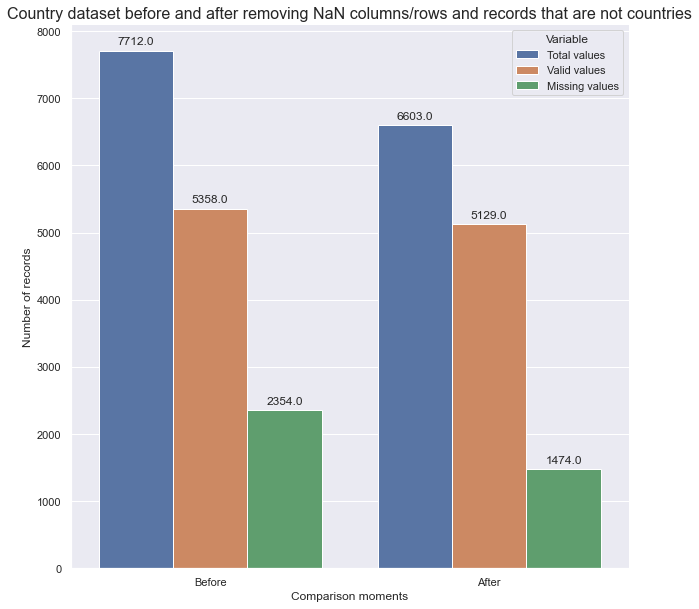

In [17]:
df_comparison = comparison_dfs(df_country, df_country_copy)
fig, ax1 = plt.subplots(figsize=(10, 10))
dt = df_comparison.melt(id_vars="Moment").rename(columns=str.title)
plot = sns.barplot(x="Moment", y="Value", data=dt, hue="Variable", ax=ax1)
for p in plot.patches:
    plot.annotate(format(p.get_height(), ".1f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="center", xytext=(0, 9), textcoords="offset points")
plt.xlabel("Comparison moments", size=12)
plt.ylabel("Number of records", size=12)
plt.title("Country dataset before and after removing NaN columns/rows and records that are not countries", size=16)
sns.despine(fig)

<a class="anchor" id="section_3_3_2"></a>
<div style="border: 1px solid RGB(68,180,231);" >
    <h4 style="margin: auto; padding: 20px; color: RGB(68,180,231); ">3.3.2. Cleaning "EdStatsData.csv" dataset</h4>
</div>

In [19]:
# Rows to remove based on list of countries as given in ISO 3166-1
df_data_copy[~df_data_copy["Country Code"].isin(df_countries_iso["Code"])]

,Country Name,Country Code,Indicator Name,Indicator Code,1970,1971,1972,1973,1974,1975,...,2055,2060,2065,2070,2075,2080,2085,2090,2095,2100
0,Arab World,ARB,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Arab World,ARB,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2.F,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Arab World,ARB,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2.GPI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Arab World,ARB,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2.M,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Arab World,ARB,"Adjusted net enrolment rate, primary, both sex...",SE.PRM.TENR,54.822121,54.894138,56.209438,57.267109,57.991138,59.36554,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886925,Zimbabwe,ZWE,"Youth illiterate population, 15-24 years, male...",UIS.LP.AG15T24.M,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
886926,Zimbabwe,ZWE,"Youth literacy rate, population 15-24 years, b...",SE.ADT.1524.LT.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
886927,Zimbabwe,ZWE,"Youth literacy rate, population 15-24 years, f...",SE.ADT.1524.LT.FE.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
886928,Zimbabwe,ZWE,"Youth literacy rate, population 15-24 years, g...",SE.ADT.1524.LT.FM.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
# Filter "EdStatsCountry.csv" based on the list of countries as given in ISO 3166-1
df_data_copy = df_data_copy[~df_data_copy["Country Code"].isin(df_countries_iso["Code"])]

Comparison of before and after data removing non-vountry NaN records and rows

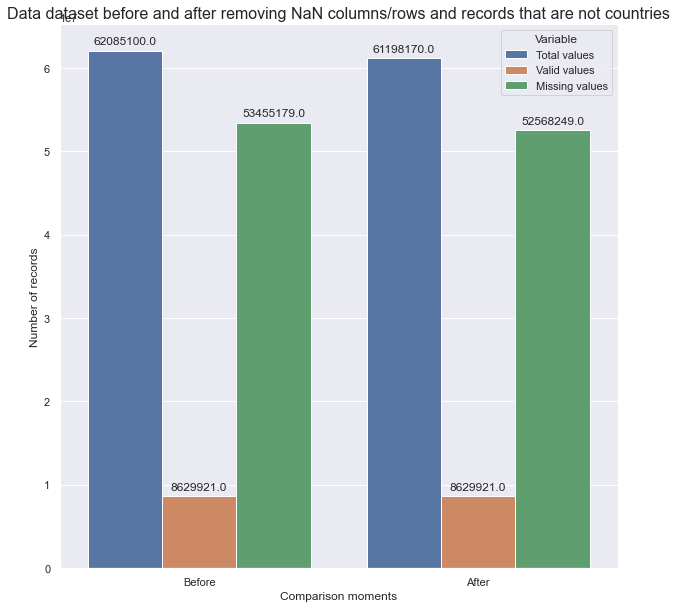

In [21]:
df_comparison = comparison_dfs(df_data, df_data_copy)
fig, ax1 = plt.subplots(figsize=(10, 10))
dt = df_comparison.melt(id_vars="Moment").rename(columns=str.title)
plot = sns.barplot(x="Moment", y="Value", data=dt, hue="Variable", ax=ax1)
for p in plot.patches:
    plot.annotate(format(p.get_height(), ".1f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="center", xytext=(0, 9), textcoords="offset points")
plt.xlabel("Comparison moments", size=12)
plt.ylabel("Number of records", size=12)
plt.title("Data dataset before and after removing NaN columns/rows and records that are not countries", size=16)
sns.despine(fig)

In [22]:
# Deleting the NaN columns and copying the data into new datasets to work on them
df_country_copy = df_country.dropna(axis="columns", how="all").dropna(axis="rows", how="all")
df_serie_copy = df_serie.dropna(axis="columns", how="all").dropna(axis="rows", how="all")
df_data_copy = df_data.dropna(axis="columns", how="all").dropna(axis="rows", how="all")

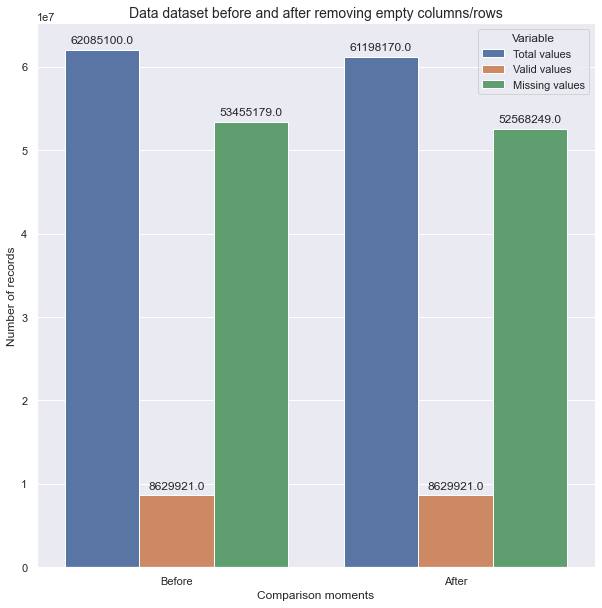

In [23]:
df_comparison = comparison_dfs(df_data, df_data_copy)
fig, ax1 = plt.subplots(figsize=(10, 10))
dt = df_comparison.melt(id_vars="Moment").rename(columns=str.title)
plot = sns.barplot(x="Moment", y="Value", data=dt, hue="Variable", ax=ax1)
for p in plot.patches:
    plot.annotate(format(p.get_height(), ".1f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="center", xytext=(0, 9), textcoords="offset points")
plt.xlabel("Comparison moments", size=12)
plt.ylabel("Number of records", size=12)
plt.title("Data dataset before and after removing empty columns/rows", size=14)
sns.despine(fig)

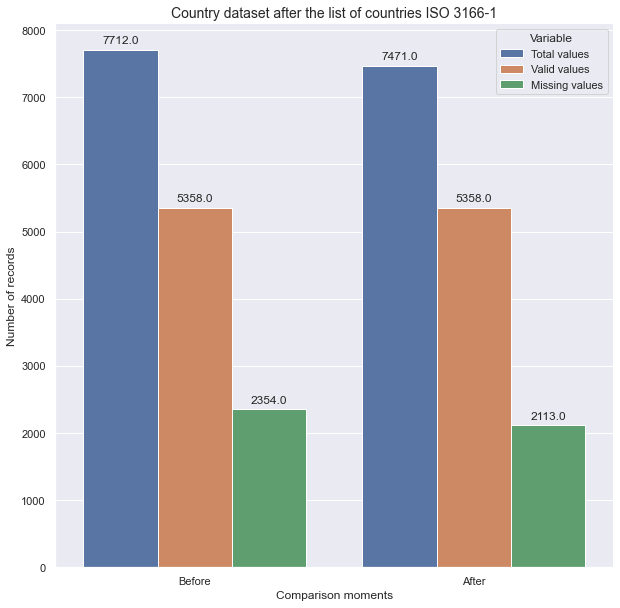

In [24]:
df_comparison = comparison_dfs(df_country, df_country_copy)
fig, ax1 = plt.subplots(figsize=(10, 10))
dt = df_comparison.melt(id_vars="Moment").rename(columns=str.title)
plot = sns.barplot(x="Moment", y="Value", data=dt, hue="Variable", ax=ax1)
for p in plot.patches:
    plot.annotate(format(p.get_height(), ".1f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="center", xytext=(0, 9), textcoords="offset points")
plt.xlabel("Comparison moments", size=12)
plt.ylabel("Number of records", size=12)
plt.title("Country dataset after the list of countries ISO 3166-1", size=14)
sns.despine(fig)

#### 3.3.

<a class="anchor" id="section_3_3"></a>
<div style="border: 1px solid RGB(119, 150, 203);" >
    <h3 style="margin: auto; padding: 20px; color: RGB(119, 150, 203); ">3.3. Selecting the initial indicators</h3>
</div>

In [25]:
Selecting the initial indicator based on the main dataset **`"EdStatsData.csv"`**

SyntaxError: invalid syntax (<ipython-input-25-33622d1027b3>, line 1)

In [ ]:
INDICATORS = (
    "internet", "computer", "capita", "GDP", "population", "education", 
    "secondary", "university", "college", "school", "bachelor", "financing", 
    "funding"
)

In [ ]:
data_sample = pd.DataFrame(data_sample[data_sample["Indicator Name"].reset_index().stack().str.contains("|".join(INDICATORS), case=False, na=False)                             .any(level=0)])

In [ ]:
data_sample["Indicator Name"].nunique() 

In [ ]:
data_sample.shape

In [ ]:
data_sample.describe()